In [2]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random

In [4]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [5]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [6]:
tf.keras.backend.clear_session()

In [7]:
subject = 'Mato_Grosso_do_Sul - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [8]:
data = pd.read_csv('2003_raw_Mato_Grosso_do_Sul_input.csv')
pd.set_option('display.max_columns', None)
data = data.replace(-1.0, np.nan)
data

,data,Mato_Grosso_do_Sul - PIB - Per Capita,Mato_Grosso_do_Sul - PIB - Preços de Mercado,Mato_Grosso_do_Sul - PIB - Estadual,Mato_Grosso_do_Sul - PIB - Construção Civil,Mato_Grosso_do_Sul - População,Mato_Grosso_do_Sul - INCC (%),Mato_Grosso_do_Sul - IPCA - Variação mensal durante o Plano Real (%),Mato_Grosso_do_Sul - IGP-DI,Mato_Grosso_do_Sul - Taxa Selic (%),Mato_Grosso_do_Sul - IDH - Longevidade,Mato_Grosso_do_Sul - IDH - Renda,Mato_Grosso_do_Sul - IDH - Educação,Mato_Grosso_do_Sul - NFSP - Fluxo Mensal (Milhões de reais),Mato_Grosso_do_Sul - Estoque liquido de capital fixo - (R$),Mato_Grosso_do_Sul - Desemprego,Mato_Grosso_do_Sul - Produção de Cimento (t),Mato_Grosso_do_Sul - Valor,Mato_Grosso_do_Sul - Consumo de Cimento (t)
0,2003-01-01,2.313678e+06,1.217888e+06,1.080843,1.410316e+06,2140624.0,1.70,12.53,2.70,0.082293,0.752,0.687,0.445,3.46,6.098524e+06,8.495092,NaN,0.370,33744.0
1,2003-02-01,2.313678e+06,1.217888e+06,1.080843,1.410316e+06,2140624.0,1.51,2.25,2.17,0.088771,0.752,0.687,0.445,3.59,6.172460e+06,8.495092,NaN,0.370,32230.0
2,2003-03-01,2.313678e+06,1.217888e+06,1.080843,1.410316e+06,2140624.0,1.39,3.86,1.59,0.090733,0.752,0.687,0.445,3.84,6.172460e+06,8.495092,51061.0,0.370,33559.0
3,2003-04-01,2.313678e+06,1.217888e+06,1.080843,1.410316e+06,2140624.0,1.38,5.13,1.66,0.092749,0.752,0.687,0.445,3.95,6.172460e+06,8.495092,94627.0,0.370,34283.0
4,2003-05-01,2.313678e+06,1.217888e+06,1.080843,1.410316e+06,2140624.0,0.90,6.15,0.41,0.092758,0.752,0.687,0.445,4.06,6.172460e+06,8.495092,96066.0,0.380,36066.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2019-08-01,4.750251e+06,8.015299e+06,1.733969,2.347819e+06,2748023.0,0.58,2.42,-0.01,0.024620,0.850,0.750,0.710,0.69,7.827728e+06,12.300000,234062.0,0.420,82888.0
200,2019-09-01,4.750251e+06,8.015299e+06,1.733969,2.347819e+06,2748023.0,0.42,2.54,-0.51,0.022751,0.850,0.750,0.710,0.62,7.827728e+06,12.000000,22584.0,0.415,79287.0
201,2019-10-01,4.750251e+06,8.015299e+06,1.733969,2.347819e+06,2748023.0,0.46,2.49,0.50,0.022035,0.850,0.750,0.710,0.59,7.827728e+06,11.900000,199752.0,0.415,81855.0
202,2019-11-01,4.750251e+06,8.015299e+06,1.733969,2.347819e+06,2748023.0,0.18,2.60,0.55,0.020790,0.850,0.750,0.710,0.57,7.827728e+06,11.700000,11465.0,0.415,77495.0


In [9]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data = target_data/1000
target_data

0      33.550
1      33.682
2      40.149
3      39.205
4      38.897
        ...  
199       NaN
200       NaN
201       NaN
202       NaN
203       NaN
Name: Mato_Grosso_do_Sul - Consumo de Cimento (t), Length: 204, dtype: float64

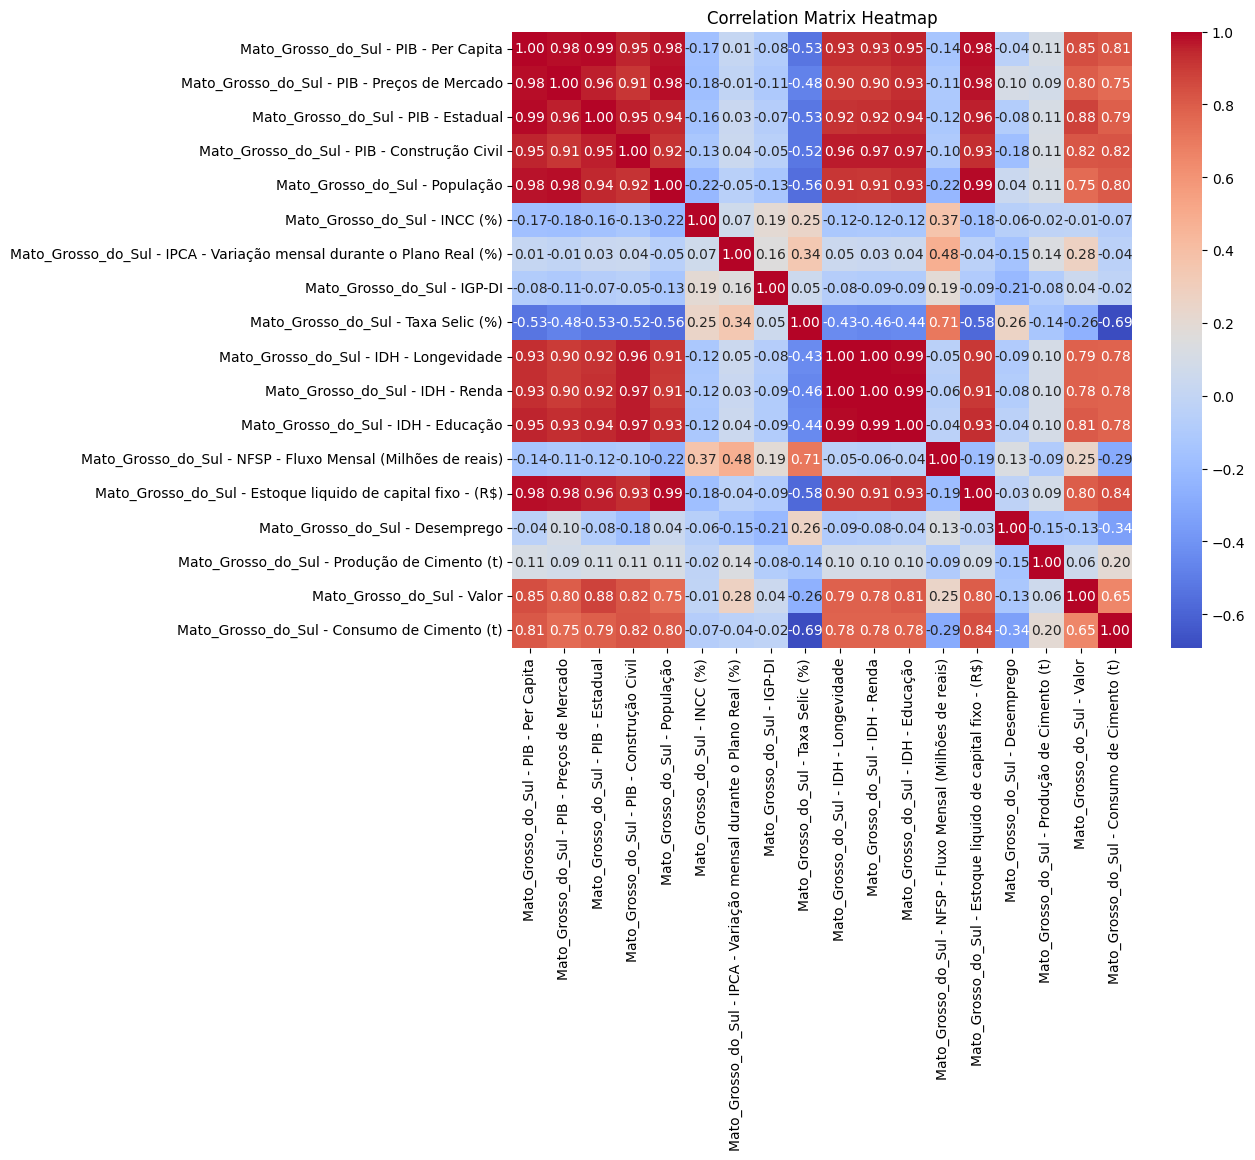

In [10]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [11]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
input_data = input_data.fillna(-1.0)
input_data

,Mato_Grosso_do_Sul - PIB - Per Capita,Mato_Grosso_do_Sul - PIB - Preços de Mercado,Mato_Grosso_do_Sul - PIB - Estadual,Mato_Grosso_do_Sul - PIB - Construção Civil,Mato_Grosso_do_Sul - População,Mato_Grosso_do_Sul - INCC (%),Mato_Grosso_do_Sul - IPCA - Variação mensal durante o Plano Real (%),Mato_Grosso_do_Sul - IGP-DI,Mato_Grosso_do_Sul - Taxa Selic (%),Mato_Grosso_do_Sul - IDH - Longevidade,Mato_Grosso_do_Sul - IDH - Renda,Mato_Grosso_do_Sul - IDH - Educação,Mato_Grosso_do_Sul - NFSP - Fluxo Mensal (Milhões de reais),Mato_Grosso_do_Sul - Estoque liquido de capital fixo - (R$),Mato_Grosso_do_Sul - Desemprego,Mato_Grosso_do_Sul - Produção de Cimento (t),Mato_Grosso_do_Sul - Valor
0,-1.368230,-1.233659,-1.323368,-1.055976,-1.517287,1.998868,4.052332,3.466715,2.303195,-0.929992,-0.931811,-0.925354,3.108599,-1.539424,0.484015,-1.000000,-0.249761
1,-1.368230,-1.233659,-1.323368,-1.055976,-1.517287,1.647487,-0.596188,2.630940,2.745235,-0.929992,-0.931811,-0.925354,3.275709,-1.411460,0.484015,-1.000000,-0.249761
2,-1.368230,-1.233659,-1.323368,-1.055976,-1.517287,1.425561,0.131839,1.716318,2.879123,-0.929992,-0.931811,-0.925354,3.597074,-1.411460,0.484015,-0.625215,-0.249761
3,-1.368230,-1.233659,-1.323368,-1.055976,-1.517287,1.407068,0.706121,1.826703,3.016721,-0.929992,-0.931811,-0.925354,3.738475,-1.411460,0.484015,-0.481484,-0.249761
4,-1.368230,-1.233659,-1.323368,-1.055976,-1.517287,0.519367,1.167355,-0.144465,3.017322,-0.929992,-0.931811,-0.925354,3.879875,-1.411460,0.484015,-0.476736,-0.060620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1.485455,1.897848,1.328978,1.090222,1.621210,-0.590259,-0.966985,-1.264088,-0.729479,1.254331,1.379373,1.414025,-0.374997,1.441346,2.771220,-0.196934,0.695947
176,1.485455,1.897848,1.328978,1.090222,1.621210,-0.479297,-0.881068,-0.412544,-0.941281,1.254331,1.379373,1.414025,-0.439270,1.441346,2.771220,-0.708126,0.695947
177,1.485455,1.897848,1.328978,1.090222,1.621210,-1.034110,-0.808718,0.186692,-1.140710,1.254331,1.379373,1.414025,-0.503543,1.441346,2.771220,-0.217376,0.695947
178,1.485455,1.897848,1.328978,1.090222,1.621210,-0.571766,-0.614276,-0.633314,-1.226481,1.254331,1.379373,1.414025,-0.503543,1.441346,2.838394,-0.741550,0.695947


In [12]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Mato_Grosso_do_Sul - PIB - Per Capita,Mato_Grosso_do_Sul - PIB - Preços de Mercado,Mato_Grosso_do_Sul - PIB - Estadual,Mato_Grosso_do_Sul - PIB - Construção Civil,Mato_Grosso_do_Sul - População,Mato_Grosso_do_Sul - INCC (%),Mato_Grosso_do_Sul - IPCA - Variação mensal durante o Plano Real (%),Mato_Grosso_do_Sul - IGP-DI,Mato_Grosso_do_Sul - Taxa Selic (%),Mato_Grosso_do_Sul - IDH - Longevidade,Mato_Grosso_do_Sul - IDH - Renda,Mato_Grosso_do_Sul - IDH - Educação,Mato_Grosso_do_Sul - NFSP - Fluxo Mensal (Milhões de reais),Mato_Grosso_do_Sul - Estoque liquido de capital fixo - (R$),Mato_Grosso_do_Sul - Desemprego,Mato_Grosso_do_Sul - Produção de Cimento (t),Mato_Grosso_do_Sul - Valor
0,-1.36823,-1.233659,-1.323368,-1.055976,-1.517287,1.998868,4.052332,3.466715,2.303195,-0.929992,-0.931811,-0.925354,3.108599,-1.539424,0.484015,-1.000000,-0.249761
1,-1.36823,-1.233659,-1.323368,-1.055976,-1.517287,1.647487,-0.596188,2.630940,2.745235,-0.929992,-0.931811,-0.925354,3.275709,-1.411460,0.484015,-1.000000,-0.249761
2,-1.36823,-1.233659,-1.323368,-1.055976,-1.517287,1.425561,0.131839,1.716318,2.879123,-0.929992,-0.931811,-0.925354,3.597074,-1.411460,0.484015,-0.625215,-0.249761
3,-1.36823,-1.233659,-1.323368,-1.055976,-1.517287,1.407068,0.706121,1.826703,3.016721,-0.929992,-0.931811,-0.925354,3.738475,-1.411460,0.484015,-0.481484,-0.249761
4,-1.36823,-1.233659,-1.323368,-1.055976,-1.517287,0.519367,1.167355,-0.144465,3.017322,-0.929992,-0.931811,-0.925354,3.879875,-1.411460,0.484015,-0.476736,-0.060620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.31466,1.513586,1.196410,1.235746,1.440748,-0.238878,0.629248,-1.406012,0.272188,1.254331,1.012519,1.138804,0.794771,1.416222,0.756007,-1.000000,1.414685
164,1.31466,1.513586,1.196410,1.235746,1.440748,-0.608753,0.837256,-0.112926,0.272188,1.254331,1.012519,1.138804,0.730498,1.416222,0.823181,-1.000000,1.414685
165,1.31466,1.513586,1.196410,1.235746,1.440748,-0.534778,0.877953,-0.743700,0.272188,1.254331,1.012519,1.138804,0.743353,1.416222,0.890354,-1.000000,0.771603
166,1.31466,1.513586,1.196410,1.235746,1.440748,-0.756703,1.000045,-0.586006,0.248413,1.254331,1.012519,1.138804,0.614807,1.416222,0.890354,-1.000000,0.771603


In [13]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      33.550
1      33.682
2      40.149
3      39.205
4      38.897
        ...  
163    87.863
164    69.723
165    72.765
166    77.937
167    64.332
Name: Mato_Grosso_do_Sul - Consumo de Cimento (t), Length: 168, dtype: float64

In [14]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [15]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 17)

In [16]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Mato_Grosso_do_Sul - PIB - Per Capita,Mato_Grosso_do_Sul - PIB - Preços de Mercado,Mato_Grosso_do_Sul - PIB - Estadual,Mato_Grosso_do_Sul - PIB - Construção Civil,Mato_Grosso_do_Sul - População,Mato_Grosso_do_Sul - INCC (%),Mato_Grosso_do_Sul - IPCA - Variação mensal durante o Plano Real (%),Mato_Grosso_do_Sul - IGP-DI,Mato_Grosso_do_Sul - Taxa Selic (%),Mato_Grosso_do_Sul - IDH - Longevidade,Mato_Grosso_do_Sul - IDH - Renda,Mato_Grosso_do_Sul - IDH - Educação,Mato_Grosso_do_Sul - NFSP - Fluxo Mensal (Milhões de reais),Mato_Grosso_do_Sul - Estoque liquido de capital fixo - (R$),Mato_Grosso_do_Sul - Desemprego,Mato_Grosso_do_Sul - Produção de Cimento (t),Mato_Grosso_do_Sul - Valor
132,1.055637,0.912164,1.039049,0.752499,1.070185,-0.960135,1.058830,0.297077,-0.755853,1.006112,1.012519,1.138804,-0.285015,0.834026,-0.318774,2.283135,0.885088
133,1.055637,0.912164,1.039049,0.752499,1.070185,0.482379,-1.364912,-0.160234,-0.688658,1.006112,1.012519,1.138804,-0.349288,1.129318,0.017095,-1.000000,0.885088
134,1.055637,0.912164,1.039049,0.752499,1.070185,-0.534778,-1.052901,0.549386,-0.626634,1.006112,1.012519,1.138804,-0.374997,1.129318,0.218617,-1.000000,0.885088
135,1.055637,0.912164,1.039049,0.752499,1.070185,-0.627247,-0.627842,1.542855,-0.571481,1.006112,1.012519,1.138804,-0.259306,1.129318,0.084269,-1.000000,1.074230
136,1.055637,0.912164,1.039049,0.752499,1.070185,0.482379,-0.320352,-0.081387,-0.516512,1.006112,1.012519,1.138804,-0.053632,1.129318,-0.050079,-1.000000,1.074230
137,1.055637,0.912164,1.039049,0.752499,1.070185,2.646150,-0.107822,-1.500628,-0.510405,1.006112,1.012519,1.138804,0.023495,1.129318,-0.184426,-1.000000,1.074230
138,1.055637,0.912164,1.039049,0.752499,1.070185,0.075516,0.082098,-1.784477,-0.510405,1.006112,1.012519,1.138804,-0.002214,1.129318,-0.251600,-1.000000,1.074230
139,1.055637,0.912164,1.039049,0.752499,1.070185,0.241960,0.086620,-1.658322,-0.510405,1.006112,1.012519,1.138804,-0.143614,1.129318,-0.385947,-1.000000,1.263371
140,1.055637,0.912164,1.039049,0.752499,1.070185,-0.997122,0.204189,-0.696392,-0.510054,1.006112,1.012519,1.138804,-0.182178,1.129318,-0.520295,-1.000000,1.074230
141,1.055637,0.912164,1.039049,0.752499,1.070185,-0.867666,0.470982,-0.759469,-0.510405,1.006112,1.012519,1.138804,-0.105051,1.129318,-0.654642,-1.000000,1.074230


In [17]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 17)

In [17]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(72, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [18]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [19]:
def predictor(model, test_input, test_target, start_target):
    
    predictions = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        if (prediction[0][0] < 0.0):
            return None, None
        predictions.append(prediction[0][0])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    return df_results, predictions

In [22]:
def statistical_validator(train_input, train_target, test_input, test_target, start_target):
    
    pd.set_option('display.max_columns', None)
    predictions_list = []
    error_percent = []
    
    i = 0
    while i < 10:
        winner_seed = get_a_good_seed(train_input, train_target, test_input, test_target)
        trained_model, history = lstm_model(train_input, 
                                            train_target, 
                                            want_verbose=0, 
                                            seed=winner_seed)
        df_results, predictions = predictor(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
        if predictions is not None:
            display(df_results.T)
            predictions_list.append(predictions)
            i += 1
        
    predictions_means = np.mean(predictions_list, axis=0)
    results_data = []
   
    for j in range(12):
        target = test_target[start_target + j]
        error = np.abs(predictions_means[j] - target)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                            predictions_means[j], 
                            target, 
                            error])
    display("FINAL___________________________________________________________________")
    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    display(df_results.T)
        
    mae_mean = np.mean(predictions_means)
    mape_mean = np.mean(error_percent) 

    return mae_mean, mape_mean

In [23]:
mae, mape = statistical_validator(reshaped_train, 
                                  reshaped_target, 
                                  reshaped_test, 
                                  reshaped_test_target, 
                                  start_index)

[2662955650, 2142062765, 3825327929, 3676208816, 260665378, 1700003108, 109734413, 889197817, 779228296, 576338926]


Step: 0 ___________________________________________
val_loss: 61.879127502441406
winner_seed: 2662955650


Step: 1 ___________________________________________
val_loss: 67.20064544677734


Step: 2 ___________________________________________
val_loss: 34.516754150390625
winner_seed: 3825327929


Step: 3 ___________________________________________
val_loss: 61.65319061279297


Step: 4 ___________________________________________
val_loss: 68.31974792480469


Step: 5 ___________________________________________
val_loss: 56.879173278808594


Step: 6 ___________________________________________
val_loss: 51.798648834228516


Step: 7 ___________________________________________
val_loss: 65.89027404785156


Step: 8 ___________________________________________
val_loss: 49.619144439697266


Step: 9 ___________________________________________
val_loss: 62.14725875854492
1/1 [======

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,63.439941,66.289497,71.067833,68.821297,75.34848,78.032486,84.840179,84.9086,79.447662,83.641754,68.384491,73.483429
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,13.608055,0.629494,5.622833,9.273705,5.649521,8.617485,2.505821,2.020599,0.16066,1.786751,9.110512,16.871429


[2788584539, 4188292585, 2106177628, 4062429822, 1549096351, 2915015540, 4253741690, 446882913, 820501442, 2648718156]


Step: 0 ___________________________________________
val_loss: 67.02540588378906
winner_seed: 2788584539


Step: 1 ___________________________________________
val_loss: 61.02158737182617
winner_seed: 4188292585


Step: 2 ___________________________________________
val_loss: 55.537349700927734
winner_seed: 2106177628


Step: 3 ___________________________________________
val_loss: 57.78047561645508


Step: 4 ___________________________________________
val_loss: 56.077083587646484


Step: 5 ___________________________________________
val_loss: 53.441505432128906
winner_seed: 2915015540


Step: 6 ___________________________________________
val_loss: 61.662662506103516


Step: 7 ___________________________________________
val_loss: 74.96307373046875


Step: 8 ___________________________________________
val_loss: 65.87507629394531


Step: 9 _________________________________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,72.566299,72.783157,75.343124,79.611542,83.057526,85.033081,85.56514,86.445953,84.628738,83.697662,82.783813,82.244965
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,4.481697,7.123154,9.898125,1.516541,2.059525,15.61808,1.780861,3.557953,5.341736,1.842659,5.288811,25.632965


[1901486135, 2772309342, 3143111810, 3715495083, 4258224707, 3058110904, 2868248599, 537860474, 3674997010, 3327870405]


Step: 0 ___________________________________________
val_loss: 59.173824310302734
winner_seed: 1901486135


Step: 1 ___________________________________________
val_loss: 53.035247802734375
winner_seed: 2772309342


Step: 2 ___________________________________________
val_loss: 56.095947265625


Step: 3 ___________________________________________
val_loss: 55.07898712158203


Step: 4 ___________________________________________
val_loss: 52.28182601928711
winner_seed: 4258224707


Step: 5 ___________________________________________
val_loss: 69.43959045410156


Step: 6 ___________________________________________
val_loss: 50.96647262573242
winner_seed: 2868248599


Step: 7 ___________________________________________
val_loss: 55.762351989746094


Step: 8 ___________________________________________
val_loss: 61.332298278808594


Step: 9 __________________________________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,70.860199,68.553062,78.157013,80.640549,82.675011,82.295212,86.213493,90.873764,84.12587,81.388954,80.939728,81.799423
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,6.187798,2.893059,12.712013,2.545547,1.67701,12.880211,1.132507,7.985764,4.838867,0.466049,3.444725,25.187424


[1733721515, 263520666, 3117037884, 2302506821, 740667372, 123398123, 3946644280, 2679382789, 3946313238, 2328637653]


Step: 0 ___________________________________________
val_loss: 55.311805725097656
winner_seed: 1733721515


Step: 1 ___________________________________________
val_loss: 71.01412963867188


Step: 2 ___________________________________________
val_loss: 65.43006896972656


Step: 3 ___________________________________________
val_loss: 55.0921630859375
winner_seed: 2302506821


Step: 4 ___________________________________________
val_loss: 53.98634719848633
winner_seed: 740667372


Step: 5 ___________________________________________
val_loss: 67.18607330322266


Step: 6 ___________________________________________
val_loss: 66.9836196899414


Step: 7 ___________________________________________
val_loss: 62.3400764465332


Step: 8 ___________________________________________
val_loss: 66.55805969238281


Step: 9 ___________________________________________
val_loss: 65.80252075

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,68.113869,66.598587,73.97319,79.37999,81.336105,83.308876,84.696289,88.111877,85.822754,84.853058,82.585258,81.187737
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,8.934128,0.938583,8.528191,1.284988,0.338104,13.893875,2.649712,5.223877,6.535751,2.998055,5.090256,24.575737


[1407530011, 2261127038, 3814185631, 1942466513, 2292354011, 2709764052, 2965346042, 418429534, 305153526, 3129890509]


Step: 0 ___________________________________________
val_loss: 57.79450607299805
winner_seed: 1407530011


Step: 1 ___________________________________________
val_loss: 63.07228469848633


Step: 2 ___________________________________________
val_loss: 61.49412155151367


Step: 3 ___________________________________________
val_loss: 54.326148986816406
winner_seed: 1942466513


Step: 4 ___________________________________________
val_loss: 60.207244873046875


Step: 5 ___________________________________________
val_loss: 71.89572143554688


Step: 6 ___________________________________________
val_loss: 50.00640869140625
winner_seed: 2965346042


Step: 7 ___________________________________________
val_loss: 51.77585983276367


Step: 8 ___________________________________________
val_loss: 56.398704528808594


Step: 9 ___________________________________________
val_loss: 58.5

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,70.103516,69.451729,75.799782,77.144402,77.378792,77.82914,79.83551,82.022118,80.473984,78.440819,75.291252,73.508354
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,6.944481,3.791725,10.354782,0.9506,3.619209,8.414139,7.51049,0.865883,1.186981,3.414185,2.203751,16.896355


[3817245260, 2721240197, 1078505544, 2819881097, 1473440021, 599795136, 2919059759, 3202787599, 3037735086, 1314865906]


Step: 0 ___________________________________________
val_loss: 62.8044548034668
winner_seed: 3817245260


Step: 1 ___________________________________________
val_loss: 52.77266311645508
winner_seed: 2721240197


Step: 2 ___________________________________________
val_loss: 60.10376739501953


Step: 3 ___________________________________________
val_loss: 49.86970901489258
winner_seed: 2819881097


Step: 4 ___________________________________________
val_loss: 55.51612091064453


Step: 5 ___________________________________________
val_loss: 51.775299072265625


Step: 6 ___________________________________________
val_loss: 47.93251419067383
winner_seed: 2919059759


Step: 7 ___________________________________________
val_loss: 44.21984100341797
winner_seed: 3202787599


Step: 8 ___________________________________________
val_loss: 59.52061080932617


Step: 9 ____________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,71.387917,67.109932,73.996582,73.935532,76.230591,80.920036,84.949547,90.344307,86.161209,82.812637,77.97168,79.294441
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,5.66008,1.449928,8.551582,4.15947,4.76741,11.505035,2.396454,7.456306,6.874207,0.957634,0.476677,22.682442


[3620147130, 508207377, 2864936408, 2231236172, 3672206812, 239974062, 2714292054, 1958292366, 1745360597, 821064316]


Step: 0 ___________________________________________
val_loss: 70.88216400146484
winner_seed: 3620147130


Step: 1 ___________________________________________
val_loss: 59.873046875
winner_seed: 508207377


Step: 2 ___________________________________________
val_loss: 63.5676383972168


Step: 3 ___________________________________________
val_loss: 65.92124938964844


Step: 4 ___________________________________________
val_loss: 64.22663879394531


Step: 5 ___________________________________________
val_loss: 59.48199462890625
winner_seed: 239974062


Step: 6 ___________________________________________
val_loss: 69.38053894042969


Step: 7 ___________________________________________
val_loss: 60.05179977416992


Step: 8 ___________________________________________
val_loss: 61.16134262084961


Step: 9 ___________________________________________
val_loss: 62.8715896606445

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,69.543488,70.1474,75.466934,78.55674,81.037796,81.429268,84.707344,87.838501,80.381447,83.304901,76.766953,81.249496
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,7.504509,4.487396,10.021935,0.461739,0.039795,12.014267,2.638657,4.9505,1.094444,1.449898,0.72805,24.637497


[2648126901, 2083706129, 3621811288, 1296211500, 2601706753, 4059413254, 3366817432, 2633308634, 1613922565, 272789196]


Step: 0 ___________________________________________
val_loss: 49.43845748901367
winner_seed: 2648126901


Step: 1 ___________________________________________
val_loss: 59.46163558959961


Step: 2 ___________________________________________
val_loss: 60.07125473022461


Step: 3 ___________________________________________
val_loss: 62.64208984375


Step: 4 ___________________________________________
val_loss: 47.182647705078125
winner_seed: 2601706753


Step: 5 ___________________________________________
val_loss: 58.856998443603516


Step: 6 ___________________________________________
val_loss: 55.95027542114258


Step: 7 ___________________________________________
val_loss: 60.41681671142578


Step: 8 ___________________________________________
val_loss: 53.32828903198242


Step: 9 ___________________________________________
val_loss: 68.06825256347656
1/1 [========

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,64.738091,66.68264,71.217026,79.879105,79.005501,82.827042,81.721527,88.187027,76.335129,83.284653,72.896454,77.43084
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,12.309906,1.022636,5.772026,1.784103,1.9925,13.412041,5.624474,5.299026,2.951874,1.429649,4.598549,20.81884


[2168176543, 3283280227, 176983310, 3204944226, 4041382958, 183726335, 2456536331, 3299567511, 1386573248, 865733364]


Step: 0 ___________________________________________
val_loss: 63.35813522338867
winner_seed: 2168176543


Step: 1 ___________________________________________
val_loss: 57.07564163208008
winner_seed: 3283280227


Step: 2 ___________________________________________
val_loss: 60.47591781616211


Step: 3 ___________________________________________
val_loss: 50.45441818237305
winner_seed: 3204944226


Step: 4 ___________________________________________
val_loss: 54.46335220336914


Step: 5 ___________________________________________
val_loss: 55.316139221191406


Step: 6 ___________________________________________
val_loss: 56.92652130126953


Step: 7 ___________________________________________
val_loss: 58.82151412963867


Step: 8 ___________________________________________
val_loss: 53.41715621948242


Step: 9 ___________________________________________
val_loss: 40.9254

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,65.465218,74.060905,65.343491,78.240929,69.764214,78.441223,78.611534,81.433357,79.580421,80.200569,72.221931,78.451897
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,11.582779,8.400902,0.101509,0.145927,11.233788,9.026222,8.734467,1.454643,0.293419,1.654434,5.273071,21.839897


[2611263281, 1384004507, 173224020, 3961315426, 4160942731, 2073227380, 2676327083, 1405311598, 3130033883, 2126390671]


Step: 0 ___________________________________________
val_loss: 57.68054962158203
winner_seed: 2611263281


Step: 1 ___________________________________________
val_loss: 95.38377380371094


Step: 2 ___________________________________________
val_loss: 63.02870559692383


Step: 3 ___________________________________________
val_loss: 57.56764602661133
winner_seed: 3961315426


Step: 4 ___________________________________________
val_loss: 53.3844108581543
winner_seed: 4160942731


Step: 5 ___________________________________________
val_loss: 53.550994873046875


Step: 6 ___________________________________________
val_loss: 62.6133918762207


Step: 7 ___________________________________________
val_loss: 58.00213623046875


Step: 8 ___________________________________________
val_loss: 57.99933624267578


Step: 9 ___________________________________________
val_loss: 45.4930

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,69.177788,66.696579,73.09565,75.878113,76.129051,77.198936,86.919014,86.814842,84.300125,86.678528,75.949181,75.254791
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,7.870209,1.036575,7.65065,2.216888,4.86895,7.783936,0.426987,3.926842,5.013123,4.823524,1.545822,18.642792


'FINAL___________________________________________________________________'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11
Prediction,68.539627,68.837349,73.346062,77.208817,78.196304,80.731522,83.805954,86.698036,82.12574,82.830353,76.579071,78.390541
Target,77.048,65.66,65.445,78.095,80.998,69.415,87.346,82.888,79.287,81.855,77.495,56.612
Error,8.508373,3.177349,7.901062,0.886183,2.801696,11.316522,3.540046,3.810036,2.83874,0.975353,0.915929,21.778541


In [24]:
display(mae)
display(mape)

78.107445

0.08493704226059583